<a href="https://colab.research.google.com/github/Raunaq14/DLF_Assignment_3/blob/main/DLF_Assignment_3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/ChZPan/stock-market-prediction-RNN.git
%cd stock-market-prediction-RNN

Cloning into 'stock-market-prediction-RNN'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106 (from 1)
Receiving objects: 100% (106/106), 1.41 MiB | 12.33 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/stock-market-prediction-RNN


In [3]:
!ls

data  figures  README.md  src


In [4]:
!ls src

data-preparation.py  predict-stock-rnn.ipynb  rnn-models.py  utils.py


In [10]:
!ls data

2010.4.1-2012.12.31.txt  2013-2015.txt	2015-2017.txt  2017-2019.4.29.txt


In [5]:
!cat src/data-preparation.py

import os
import numpy as np
import pandas as pd
import random
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# random.seed(time.time())

class StockIndexDataset:
    def __init__(self,
                 dataset_files,
                 index_name="SH300IF",
                 batch_size=32,
                 time_steps=12,
                 forecast_steps=0,
                 val_ratio=0.2,
                 test_ratio=0.2,
                 test_only=False,
                 standardization='standard',
                 close_price_only=True):
        self.dataset_files = dataset_files
        self.index_name = index_name
        self.batch_size = batch_size
        self.time_steps = time_steps
        self.forecast_steps = forecast_steps
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.test_only = test_only
        # self.close_price_only = close_price_only
        # self.stand

In [8]:
!mv src/data-preparation.py src/data_preparation.py

In [11]:
# Combine all files in the data folder
import os
import pandas as pd

data_dir = "data"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".txt")]

# Combine into a single DataFrame
combined_df = pd.concat(
    [pd.read_table(f, delim_whitespace=True, names=["date", "time", "open", "close"]) for f in all_files],
    ignore_index=True
)

# Save the combined dataset
combined_dataset_path = "data/combined_dataset.txt"
combined_df.to_csv(combined_dataset_path, sep="\t", index=False)

print(f"Combined dataset saved at: {combined_dataset_path}")

<ipython-input-11-b3b8b38cdc14>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  [pd.read_table(f, delim_whitespace=True, names=["date", "time", "open", "close"]) for f in all_files],
<ipython-input-11-b3b8b38cdc14>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  [pd.read_table(f, delim_whitespace=True, names=["date", "time", "open", "close"]) for f in all_files],
<ipython-input-11-b3b8b38cdc14>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  [pd.read_table(f, delim_whitespace=True, names=["date", "time", "open", "close"]) for f in all_files],
<ipython-input-11-b3b8b38cdc14>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future 

Combined dataset saved at: data/combined_dataset.txt


In [14]:
import pandas as pd

# Load the combined dataset
combined_dataset_path = "data/combined_dataset.txt"
df = pd.read_table(combined_dataset_path, sep="\t", names=["date", "time", "open", "close"], skiprows=1)

# Inspect the first few rows
print(df.head())

         date      time     open    close
0  2015/01/05  09:35:00  3567.53  3575.19
1  2015/01/05  09:40:00  3575.52  3573.51
2  2015/01/05  09:45:00  3573.27  3573.36
3  2015/01/05  09:50:00  3573.52  3589.28
4  2015/01/05  09:55:00  3589.63  3571.76


In [15]:
# Combine 'date' and 'time' into a single datetime column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')

# Drop rows where datetime could not be parsed
df = df.dropna(subset=['datetime'])

# Drop unnecessary columns
df = df.drop(columns=['date', 'time'])

# Sort the data by datetime
df = df.sort_values(by='datetime').reset_index(drop=True)

# Check the cleaned data
print(f"Cleaned dataset shape: {df.shape}")
print(df.head())

Cleaned dataset shape: (105830, 3)
      open    close            datetime
0  3345.61  3359.57 2010-04-01 09:35:00
1  3359.83  3368.12 2010-04-01 09:40:00
2  3368.76  3371.16 2010-04-01 09:45:00
3  3370.86  3369.15 2010-04-01 09:50:00
4  3369.08  3373.68 2010-04-01 09:55:00


In [16]:
cleaned_dataset_path = "data/cleaned_combined_dataset.txt"
df.to_csv(cleaned_dataset_path, sep="\t", index=False)
print(f"Cleaned dataset saved at: {cleaned_dataset_path}")

Cleaned dataset saved at: data/cleaned_combined_dataset.txt


In [18]:
# Load the dataset and inspect
df = pd.read_csv("data/cleaned_combined_dataset.txt", sep="\t")
print(df.head())

      open    close             datetime
0  3345.61  3359.57  2010-04-01 09:35:00
1  3359.83  3368.12  2010-04-01 09:40:00
2  3368.76  3371.16  2010-04-01 09:45:00
3  3370.86  3369.15  2010-04-01 09:50:00
4  3369.08  3373.68  2010-04-01 09:55:00


In [22]:
# Load the cleaned dataset
df = pd.read_csv("data/cleaned_combined_dataset.txt", sep="\t")

# Split the 'datetime' column into 'date' and 'time' columns
df['date'] = pd.to_datetime(df['datetime']).dt.date
df['time'] = pd.to_datetime(df['datetime']).dt.time

# Drop the 'datetime' column as it's no longer needed
df = df[['date', 'time', 'open', 'close']]

# Save the modified dataset
final_dataset_path = "data/final_dataset.txt"
# Save the modified dataset without the header row
df.to_csv(final_dataset_path, sep="\t", index=False, header=False)
print(f"Final dataset saved without headers at: {final_dataset_path}")

Final dataset saved without headers at: data/final_dataset.txt


In [23]:
from src.data_preparation import StockIndexDataset

# Use the updated dataset file without headers
final_dataset_path = "data/final_dataset.txt"

# Initialize the dataset
dataset = StockIndexDataset(
    dataset_files=final_dataset_path,
    batch_size=32,       # Number of samples per batch
    time_steps=12,       # Time steps for the sequence
    forecast_steps=1,    # Forecast steps
    val_ratio=0.2,       # Validation ratio
    test_ratio=0.2,      # Test ratio
    test_only=False      # Set to False for training and validation
)

# Display dataset information
dataset.info()

/content/stock-market-prediction-RNN/src/data_preparation.py:44: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.raw_df = pd.read_table(self.dataset_files,


Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 67712
Validation Set Length: 16928
Test Set Length: 21152


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define RNN model
def create_rnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        SimpleRNN(50, return_sequences=True),
        Dropout(0.2),
        SimpleRNN(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Final output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Define LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Final output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Define GRU model
def create_gru_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        GRU(50, return_sequences=True),
        Dropout(0.2),
        GRU(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)  # Final output layer
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Get input shape from training data
input_shape = dataset.X_train.shape[1:]  # Extract shape from the dataset

# Create models
rnn_model = create_rnn_model(input_shape)
lstm_model = create_lstm_model(input_shape)
gru_model = create_gru_model(input_shape)

print("Models defined successfully.")

Models defined successfully.


In [26]:
# Train the RNN model
print("Training RNN model...")
rnn_history = rnn_model.fit(
    dataset.X_train,
    dataset.y_train,
    validation_data=(dataset.X_val, dataset.y_val),
    epochs=10,  # You can adjust the number of epochs
    batch_size=32,  # Ensure this matches the dataset batch size
    verbose=1
)

# Train the LSTM model
print("Training LSTM model...")
lstm_history = lstm_model.fit(
    dataset.X_train,
    dataset.y_train,
    validation_data=(dataset.X_val, dataset.y_val),
    epochs=10,  # You can adjust the number of epochs
    batch_size=32,
    verbose=1
)

# Train the GRU model
print("Training GRU model...")
gru_history = gru_model.fit(
    dataset.X_train,
    dataset.y_train,
    validation_data=(dataset.X_val, dataset.y_val),
    epochs=10,  # You can adjust the number of epochs
    batch_size=32,
    verbose=1
)

print("Training complete.")

Training RNN model...
Epoch 1/10
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0472 - mae: 0.1296 - val_loss: 5.6974e-04 - val_mae: 0.0195
Epoch 2/10
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.0088 - mae: 0.0662 - val_loss: 0.0012 - val_mae: 0.0312
Epoch 3/10
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0070 - mae: 0.0581 - val_loss: 4.1977e-04 - val_mae: 0.0157
Epoch 4/10
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0061 - mae: 0.0537 - val_loss: 4.1272e-04 - val_mae: 0.0147
Epoch 5/10
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0048 - mae: 0.0478 - val_loss: 5.9899e-04 - val_mae: 0.0217
Epoch 6/10
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0042 - mae: 0.0448 - val_loss: 2.7674e-04 - val_mae: 0.0128
Epoch 7/10
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0037 - mae: 0.0428 - val_loss: 9.2918e-04 - val_mae: 0.0282
Epoch 8/10
2116/2116 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0037 - mae: 0.0415 - val_loss: 3.9265e-04

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Helper function to evaluate a model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, rmse, mae, r2, predictions

# Evaluate RNN
rnn_mse, rnn_rmse, rnn_mae, rnn_r2, rnn_predictions = evaluate_model(rnn_model, dataset.X_test, dataset.y_test)
print(f"RNN - MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}, R^2: {rnn_r2:.4f}")

# Evaluate LSTM
lstm_mse, lstm_rmse, lstm_mae, lstm_r2, lstm_predictions = evaluate_model(lstm_model, dataset.X_test, dataset.y_test)
print(f"LSTM - MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, R^2: {lstm_r2:.4f}")

# Evaluate GRU
gru_mse, gru_rmse, gru_mae, gru_r2, gru_predictions = evaluate_model(gru_model, dataset.X_test, dataset.y_test)
print(f"GRU - MSE: {gru_mse:.4f}, RMSE: {gru_rmse:.4f}, MAE: {gru_mae:.4f}, R^2: {gru_r2:.4f}")

661/661 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
RNN - MSE: 0.0047, RMSE: 0.0686, MAE: 0.0573, R^2: 0.9848
661/661 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
LSTM - MSE: 0.0090, RMSE: 0.0949, MAE: 0.0825, R^2: 0.9709
661/661 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
GRU - MSE: 0.0140, RMSE: 0.1181, MAE: 0.1023, R^2: 0.9549


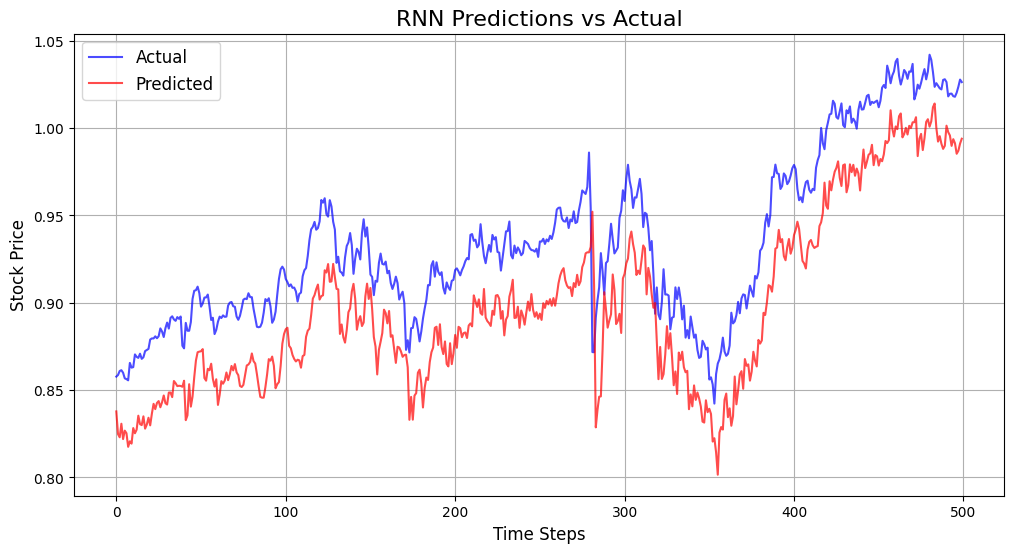

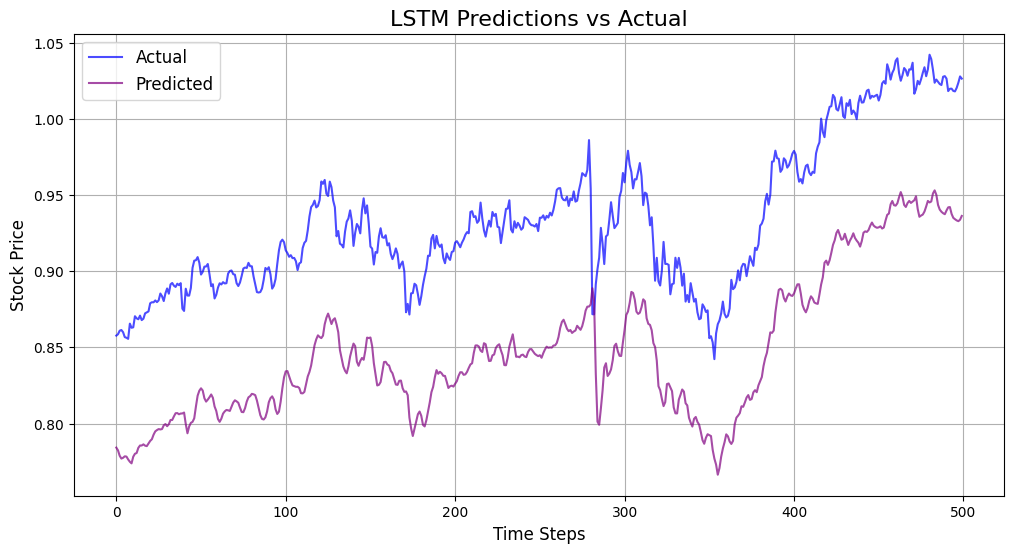

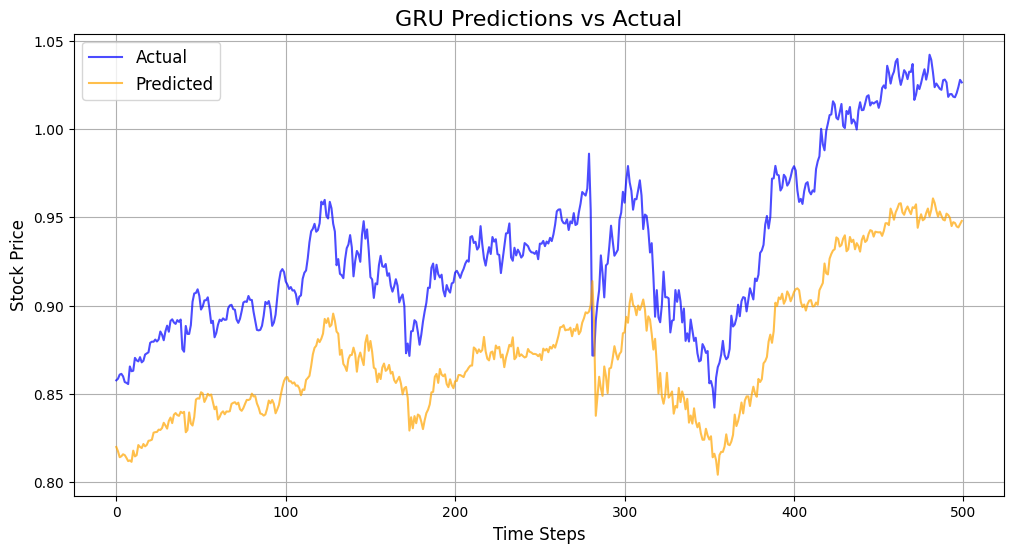

In [29]:
import matplotlib.pyplot as plt

# Helper function for visualization
def plot_predictions(actual, predicted, model_name, color_actual='blue', color_predicted='green'):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label="Actual", color=color_actual, alpha=0.7)
    plt.plot(predicted, label="Predicted", color=color_predicted, alpha=0.7)
    plt.title(f"{model_name} Predictions vs Actual", fontsize=16)
    plt.xlabel("Time Steps", fontsize=12)
    plt.ylabel("Stock Price", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Visualize RNN predictions
plot_predictions(dataset.y_test[:500], rnn_predictions[:500], "RNN", color_actual='blue', color_predicted='red')

# Visualize LSTM predictions
plot_predictions(dataset.y_test[:500], lstm_predictions[:500], "LSTM", color_actual='blue', color_predicted='purple')

# Visualize GRU predictions
plot_predictions(dataset.y_test[:500], gru_predictions[:500], "GRU", color_actual='blue', color_predicted='orange')

In [31]:
import os

# Ensure the 'results' directory exists
os.makedirs('results', exist_ok=True)

# Save metrics to a CSV file
metrics = {
    "Model": ["RNN", "LSTM", "GRU"],
    "MSE": [rnn_mse, lstm_mse, gru_mse],
    "RMSE": [rnn_rmse, lstm_rmse, gru_rmse],
    "MAE": [rnn_mae, lstm_mae, gru_mae],
    "R^2": [rnn_r2, lstm_r2, gru_r2]
}

metrics_df = pd.DataFrame(metrics)
metrics_path = "results/model_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)

print(f"Metrics saved to: {metrics_path}")

Metrics saved to: results/model_metrics.csv


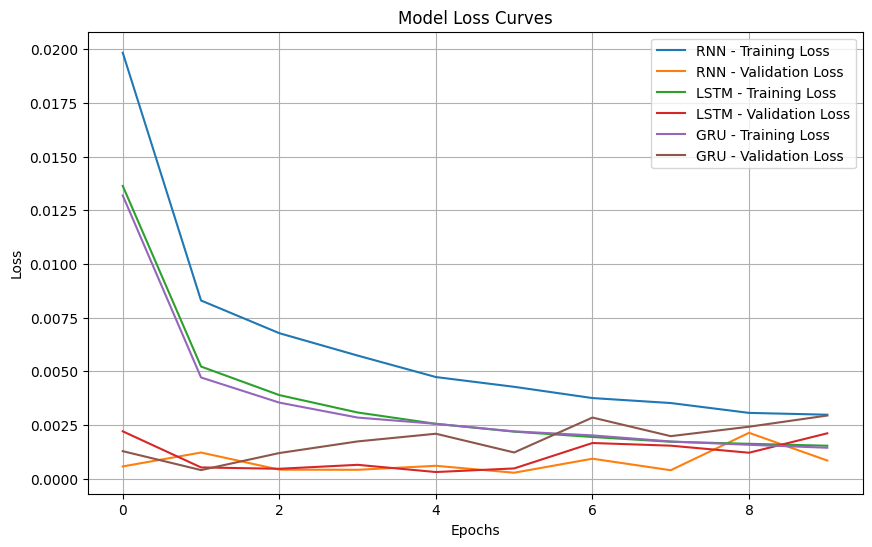

In [34]:
import matplotlib.pyplot as plt

def plot_loss_curves(histories, model_names):
    plt.figure(figsize=(10, 6))
    for history, model_name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{model_name} - Training Loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} - Validation Loss')
    plt.title('Model Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming `rnn_history`, `lstm_history`, and `gru_history` are the history objects from training
plot_loss_curves(
    [rnn_history, lstm_history, gru_history],
    ['RNN', 'LSTM', 'GRU']
)